<a href="https://colab.research.google.com/github/YoooonaLee/machine_learning/blob/main/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bagging vs Boosting

> *배깅*은 병렬적인 학습과 복원 추출을 통해 약한 학습기들을 결합하는 반면,
>
>*부스팅*은 순차적인 학습과 가중치 업데이트를 통해 약한 학습기들을 의견을 계속 반영해서 최종적인 강한 학습기로 강화 시키는것

#GBM(Gradient Boosting Machine)

#XGBoost ( Extreme Gradient Boosting)



* 정규화 항을 통한 과적합 방지
* 병렬 처리로 인한 빠른 학습
* 메모리 최적화로 대규모 데이터 처리 가능
* 손실 함수의 2차 테일러 전개를 통한 더 정확한 최적화 (헤시안)




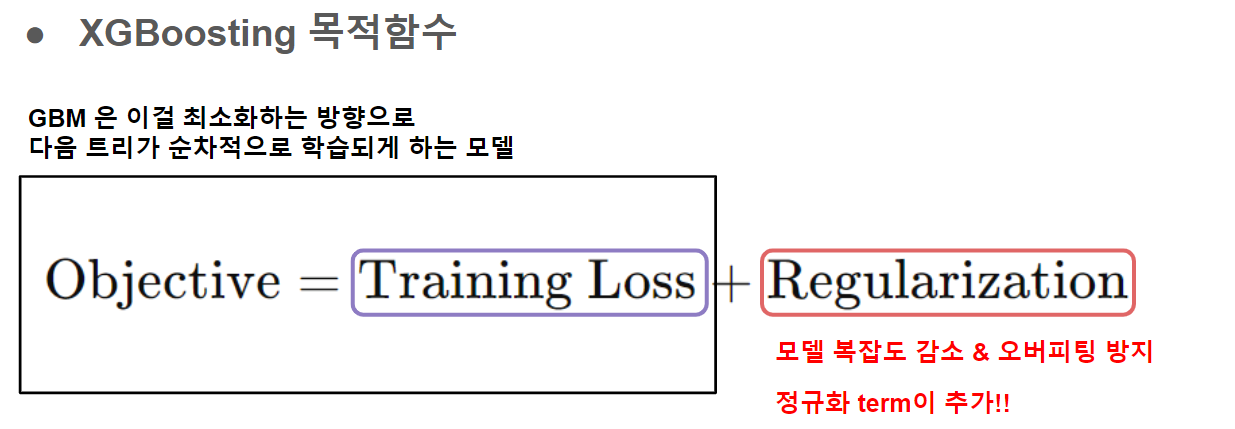

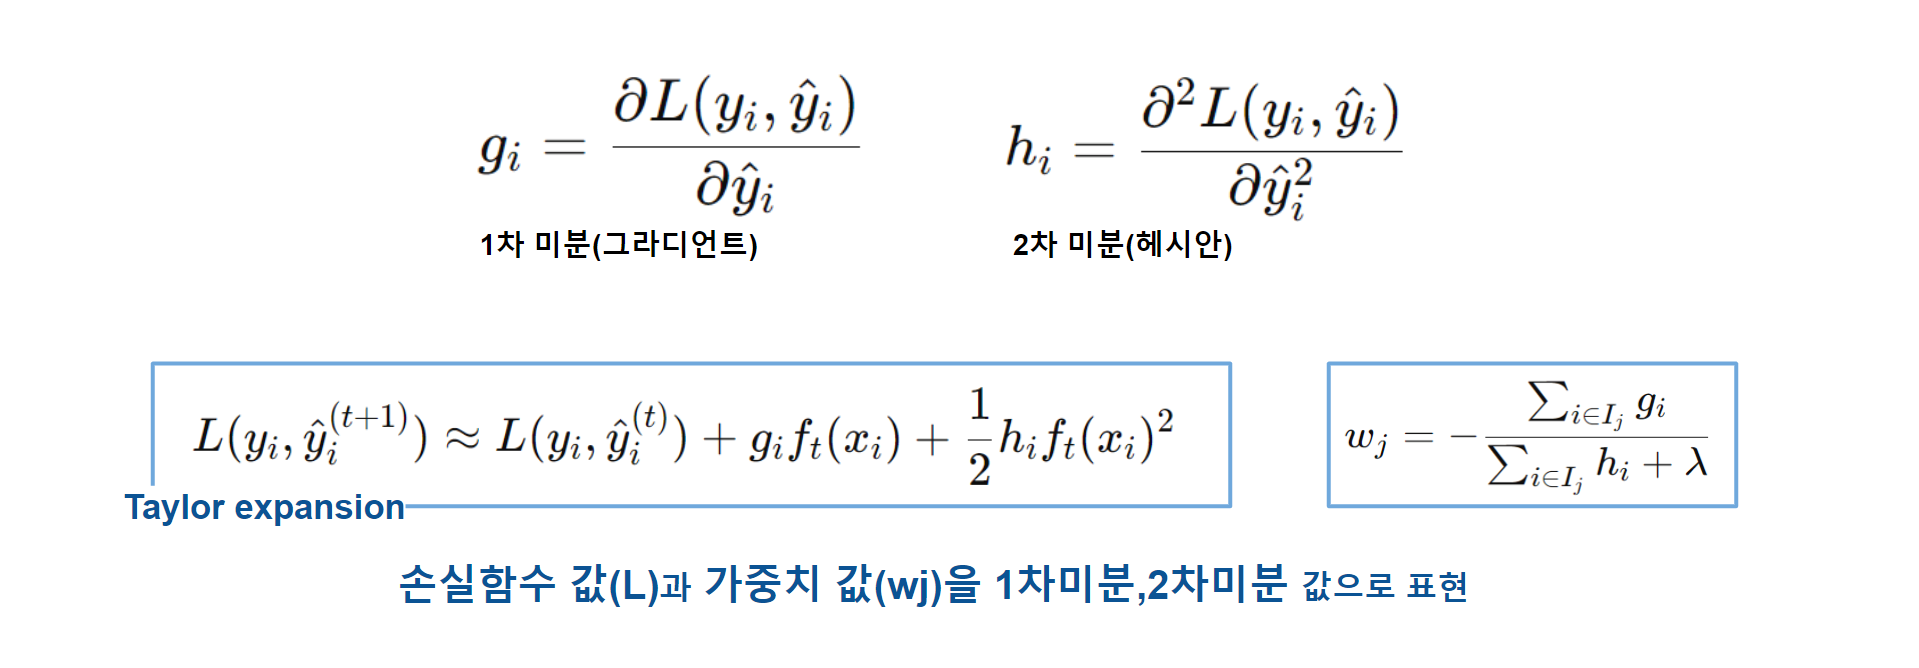

## reduction gain

decision tree에서 확장해서 생각해보면 스플릿하는 기준을 정의하기 위한
함수.

비슷한 아이디어로 역시나 스플릿되고나서 손실을 감소하는정도에서
스플릿 되기 전에 손실감소 정도를 빼서 gain값을 구한다.

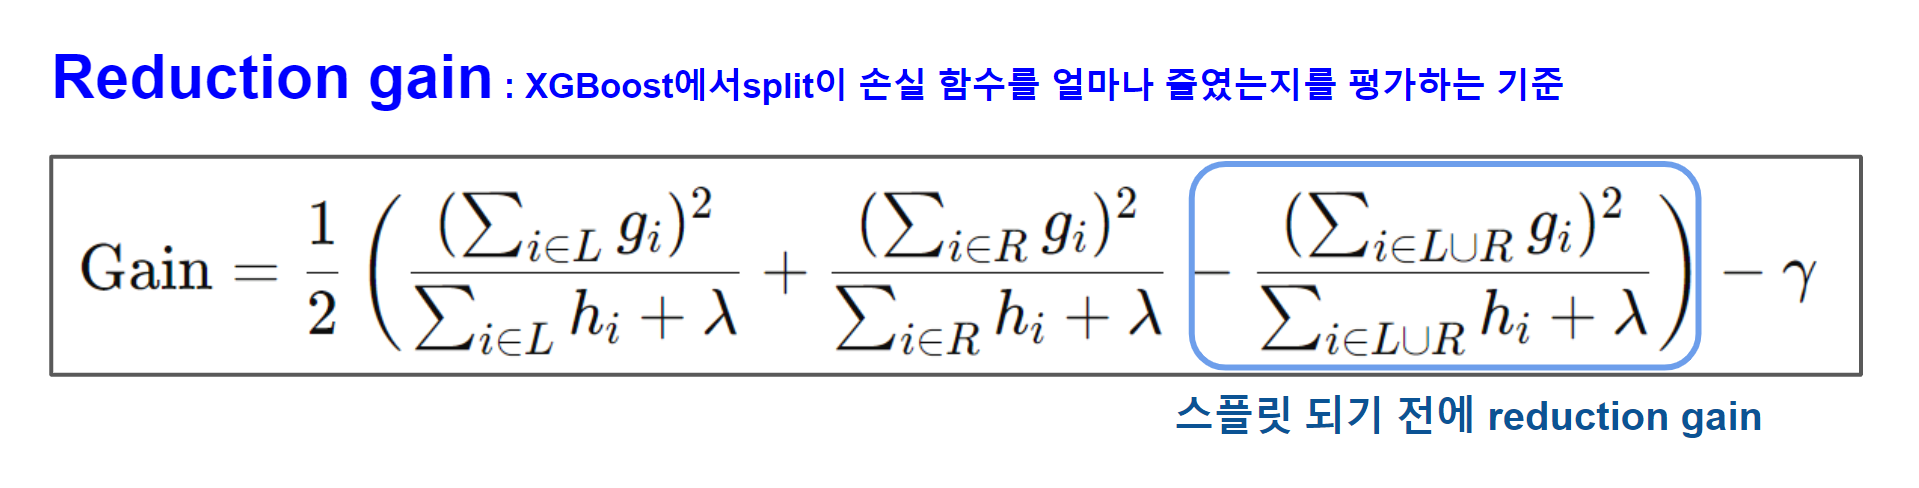

##✅ 최종 xgboost 목적함수

결국엔 부스팅 + 그라디언트 디센트 라는 두가지 강력한 조합이지만
트레이드 오프관계가 항상 존재하듯이
1. 과적합과
2. 계산비용 문제 발생


이걸 해결하기 위해서
1. 정규화항을 추가하고
2. 손실함수와 가중치값을 표현하는데 있어서
 테일러 근사의 2nd order까지만 사용




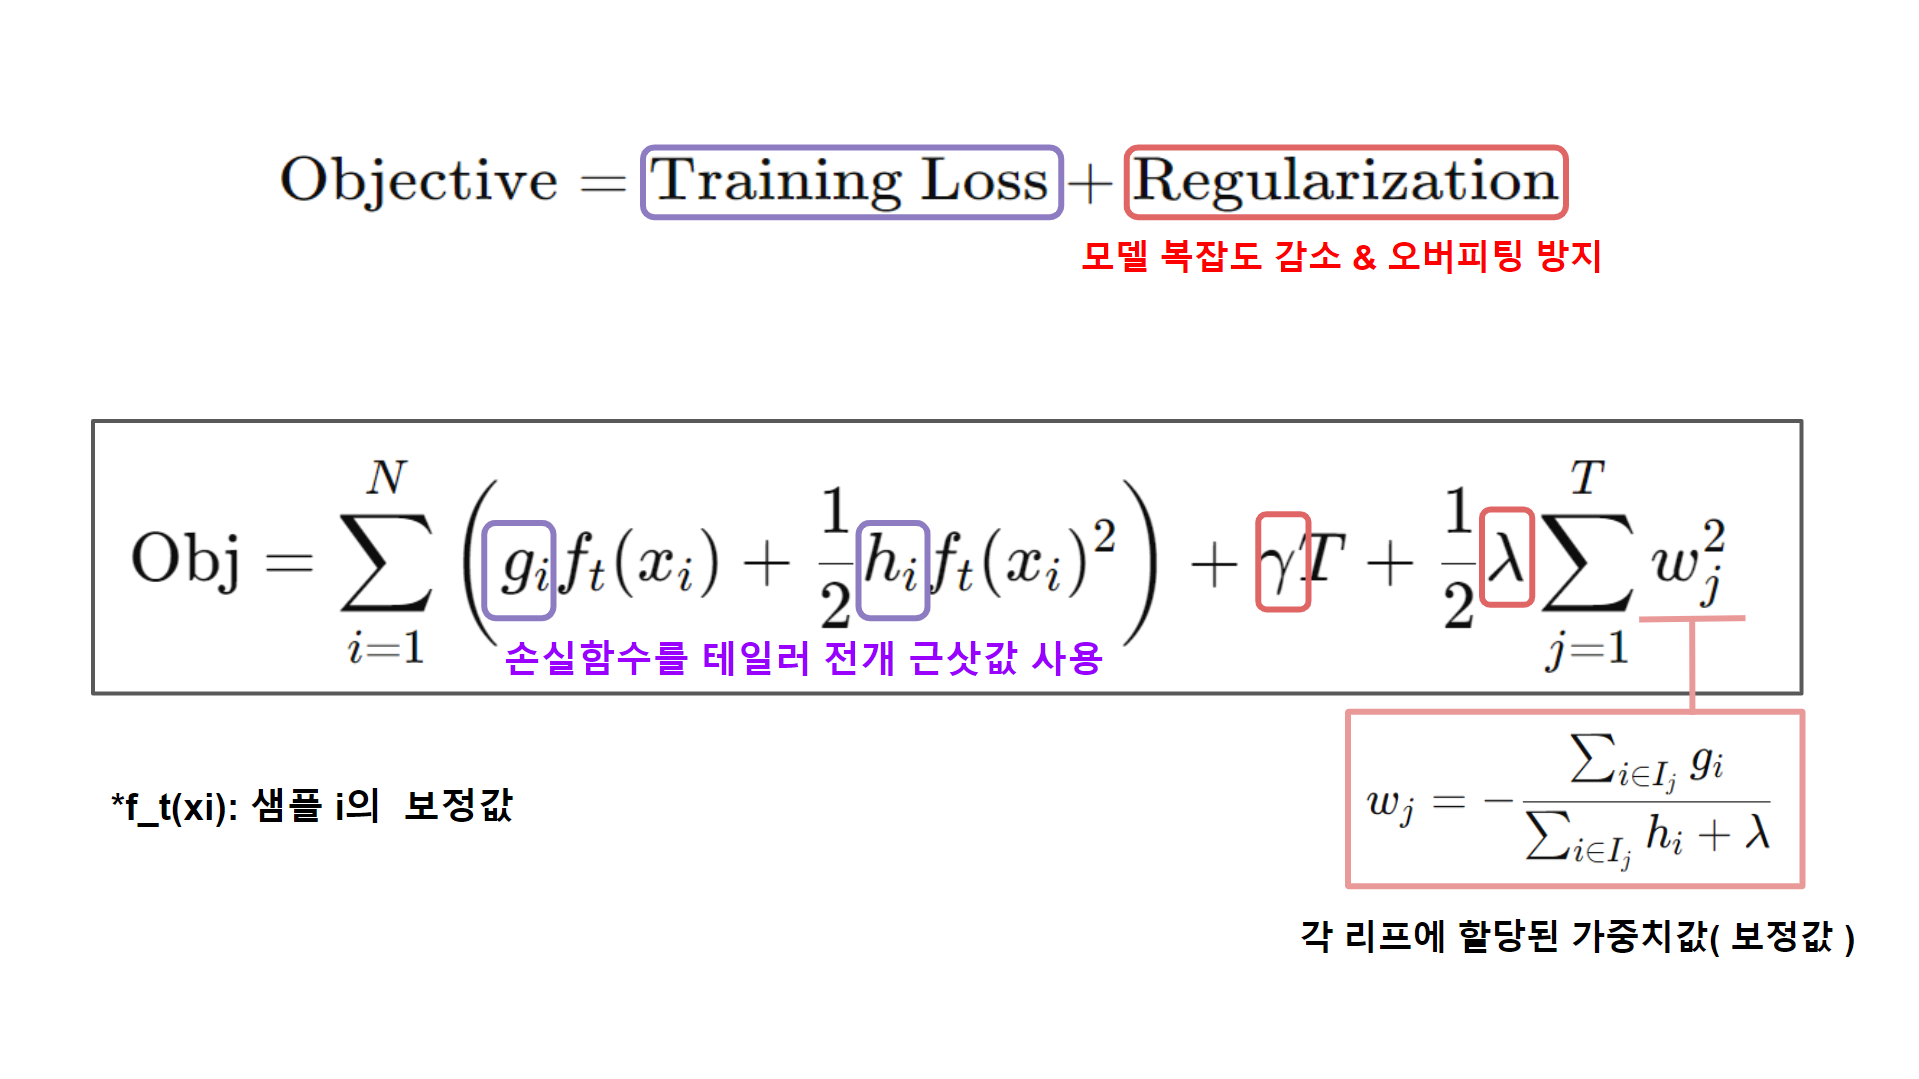

>γ(gamma): 트리가 스플릿될 때마다 γ만큼의 비용이 추가됨!!
>
>분할이 이 비용보다 더 큰 GIAN(위에서 설명한 REDUCTION GAIN)을 가져다주지 않으면, 분할 X.
>
>T:각 트리에서 생성된 리프의 개수
>
>*즉 γT는 모든 리프에 대해 고정비용을 주는 방식

>λ(lambda):L2 정규화 항

#XGBoosting 으로 와인데이터 classification

In [2]:
import pandas as pd

# 와인 데이터셋 불러오기 (레드와인, 화이트와인 합친 데이터셋)
red_wine_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
white_wine_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

# 레드와인과 화이트와인 데이터 불러오기
red_wine = pd.read_csv(red_wine_url, sep=";")
white_wine = pd.read_csv(white_wine_url, sep=";")

# 각 데이터에 'color' 열 추가 (0 = 레드와인, 1 = 화이트와인)
red_wine['color'] = 0
white_wine['color'] = 1

# 두 데이터셋을 통합
wine_data = pd.concat([red_wine, white_wine], axis=0).reset_index(drop=True)



# 특성(features)과 레이블(label) 분리
X = wine_data.drop("color", axis=1)  # 'color' 열 제외
y = wine_data["color"]  # 'color' 열이 레이블


# 데이터 프레임의 구조 확인
print(wine_data.shape)


(6497, 13)


In [3]:
wine_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1


In [4]:
wine_data['color'].value_counts()

,count
color,
1,4898
0,1599


#레드 vs화이트 와인 분류

In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터를 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# 특성 값 스케일링 (선택 사항)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# XGBoost 분류 모델 초기화 #⭐
xgb_model_cls = XGBClassifier(n_estimators=100, learning_rate=0.5, max_depth=10, use_label_encoder=False, eval_metric='logloss')

# 모델 학습
xgb_model_cls.fit(X_train, y_train)




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:19:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [36]:

y_pred = xgb_model_cls.predict(X_test)

# 정확도(accuracy) 계산
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 99.54%


                 Feature  Importance
6   total sulfur dioxide    0.453831
4              chlorides    0.367200
7                density    0.046081
1       volatile acidity    0.041388
9              sulphates    0.024463
8                     pH    0.020516
2            citric acid    0.011528
3         residual sugar    0.010885
10               alcohol    0.009583
0          fixed acidity    0.008454
11               quality    0.003317
5    free sulfur dioxide    0.002753


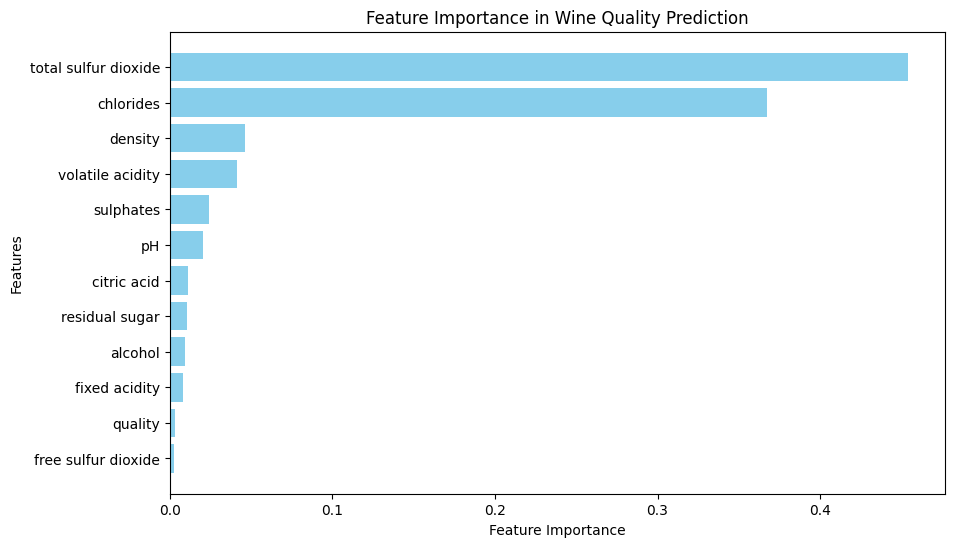

In [37]:

# 피처 중요도 추출
importance = xgb_model_cls.feature_importances_

# 피처 이름과 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 피처 중요도 출력
print(importance_df)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Wine Quality Prediction')
plt.gca().invert_yaxis()  # 상위 중요도를 위로 올림
plt.show()



6   total sulfur dioxide    0.471718

4              chlorides    0.340817

1       volatile acidity    0.050498

7                density    0.041762

높은 피처 중요도!!

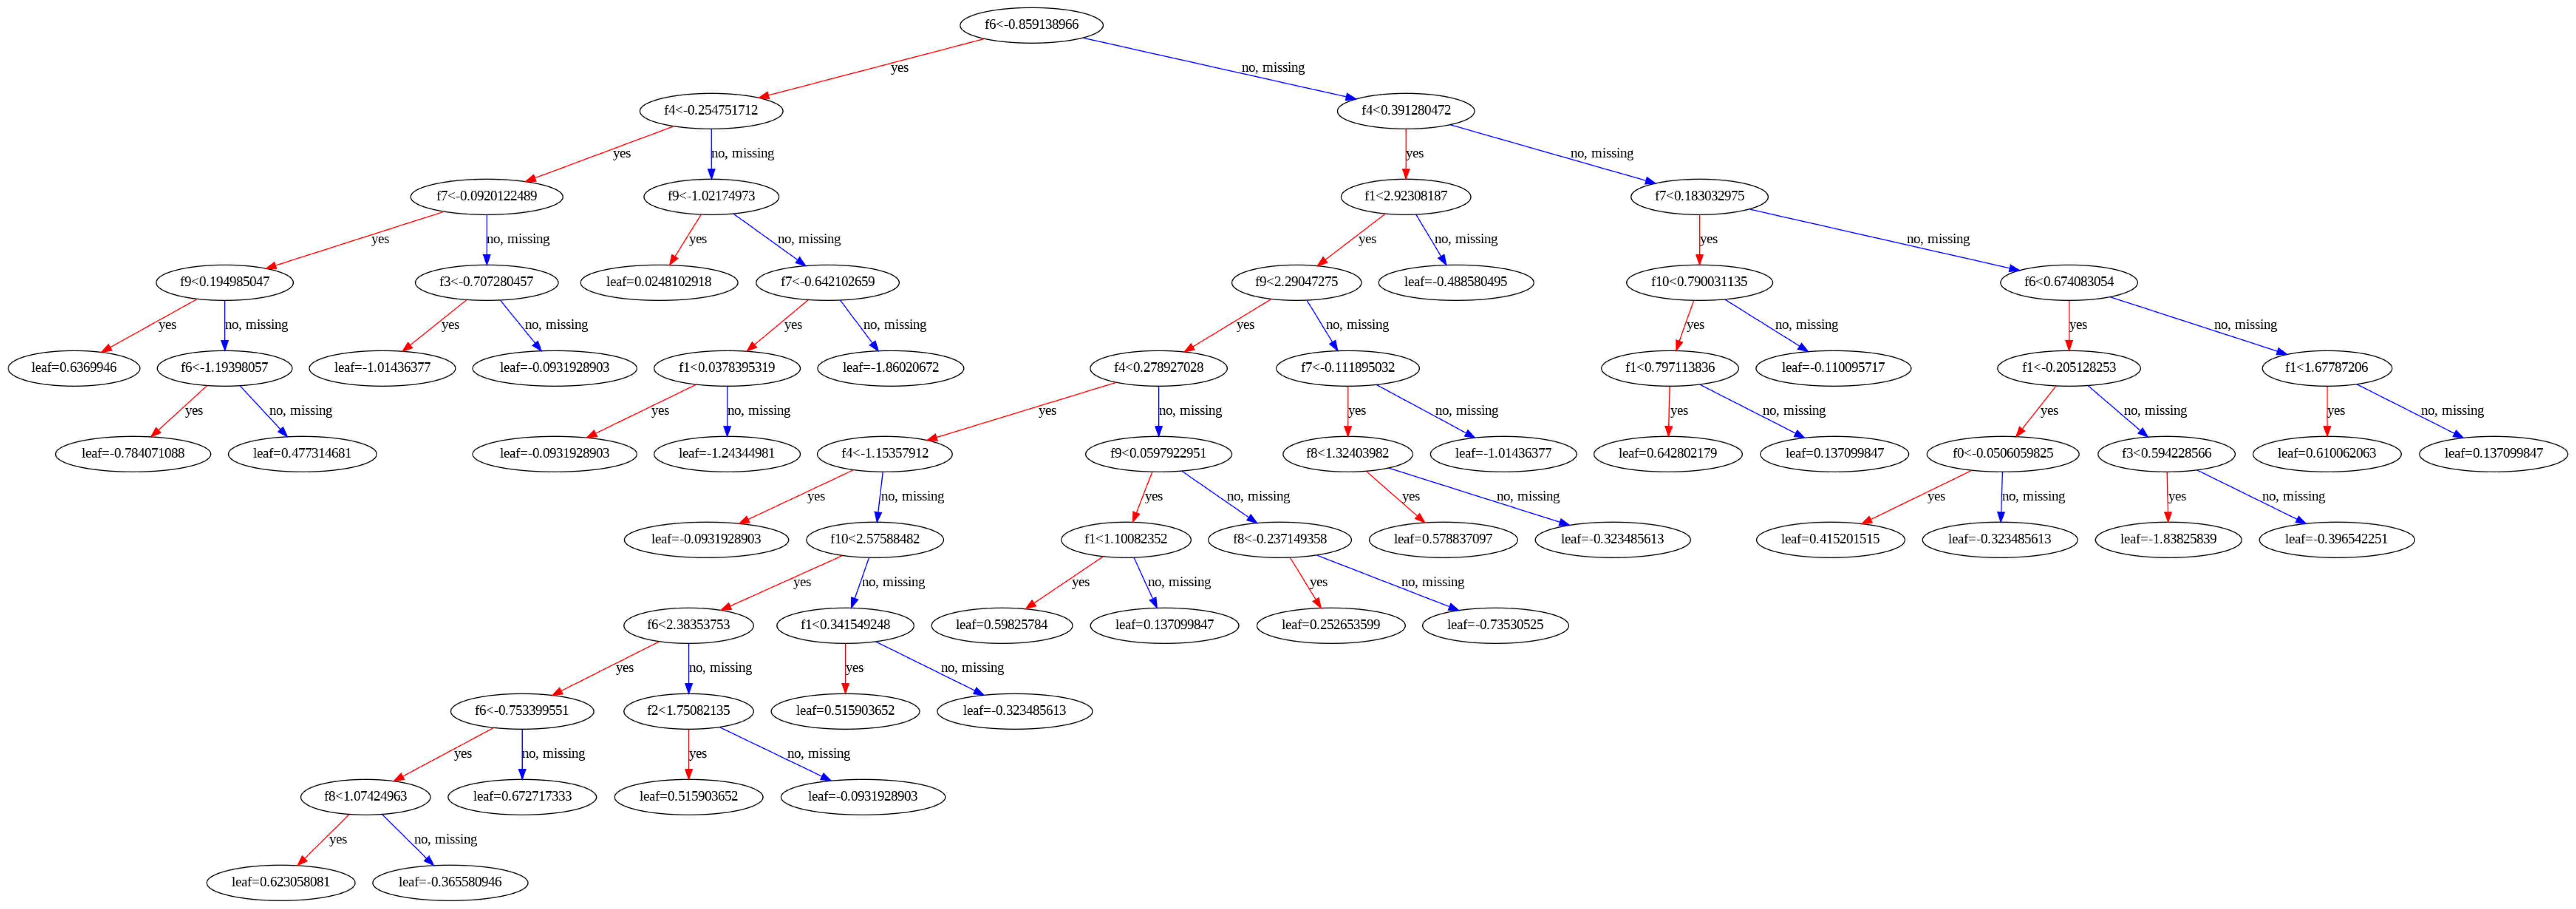

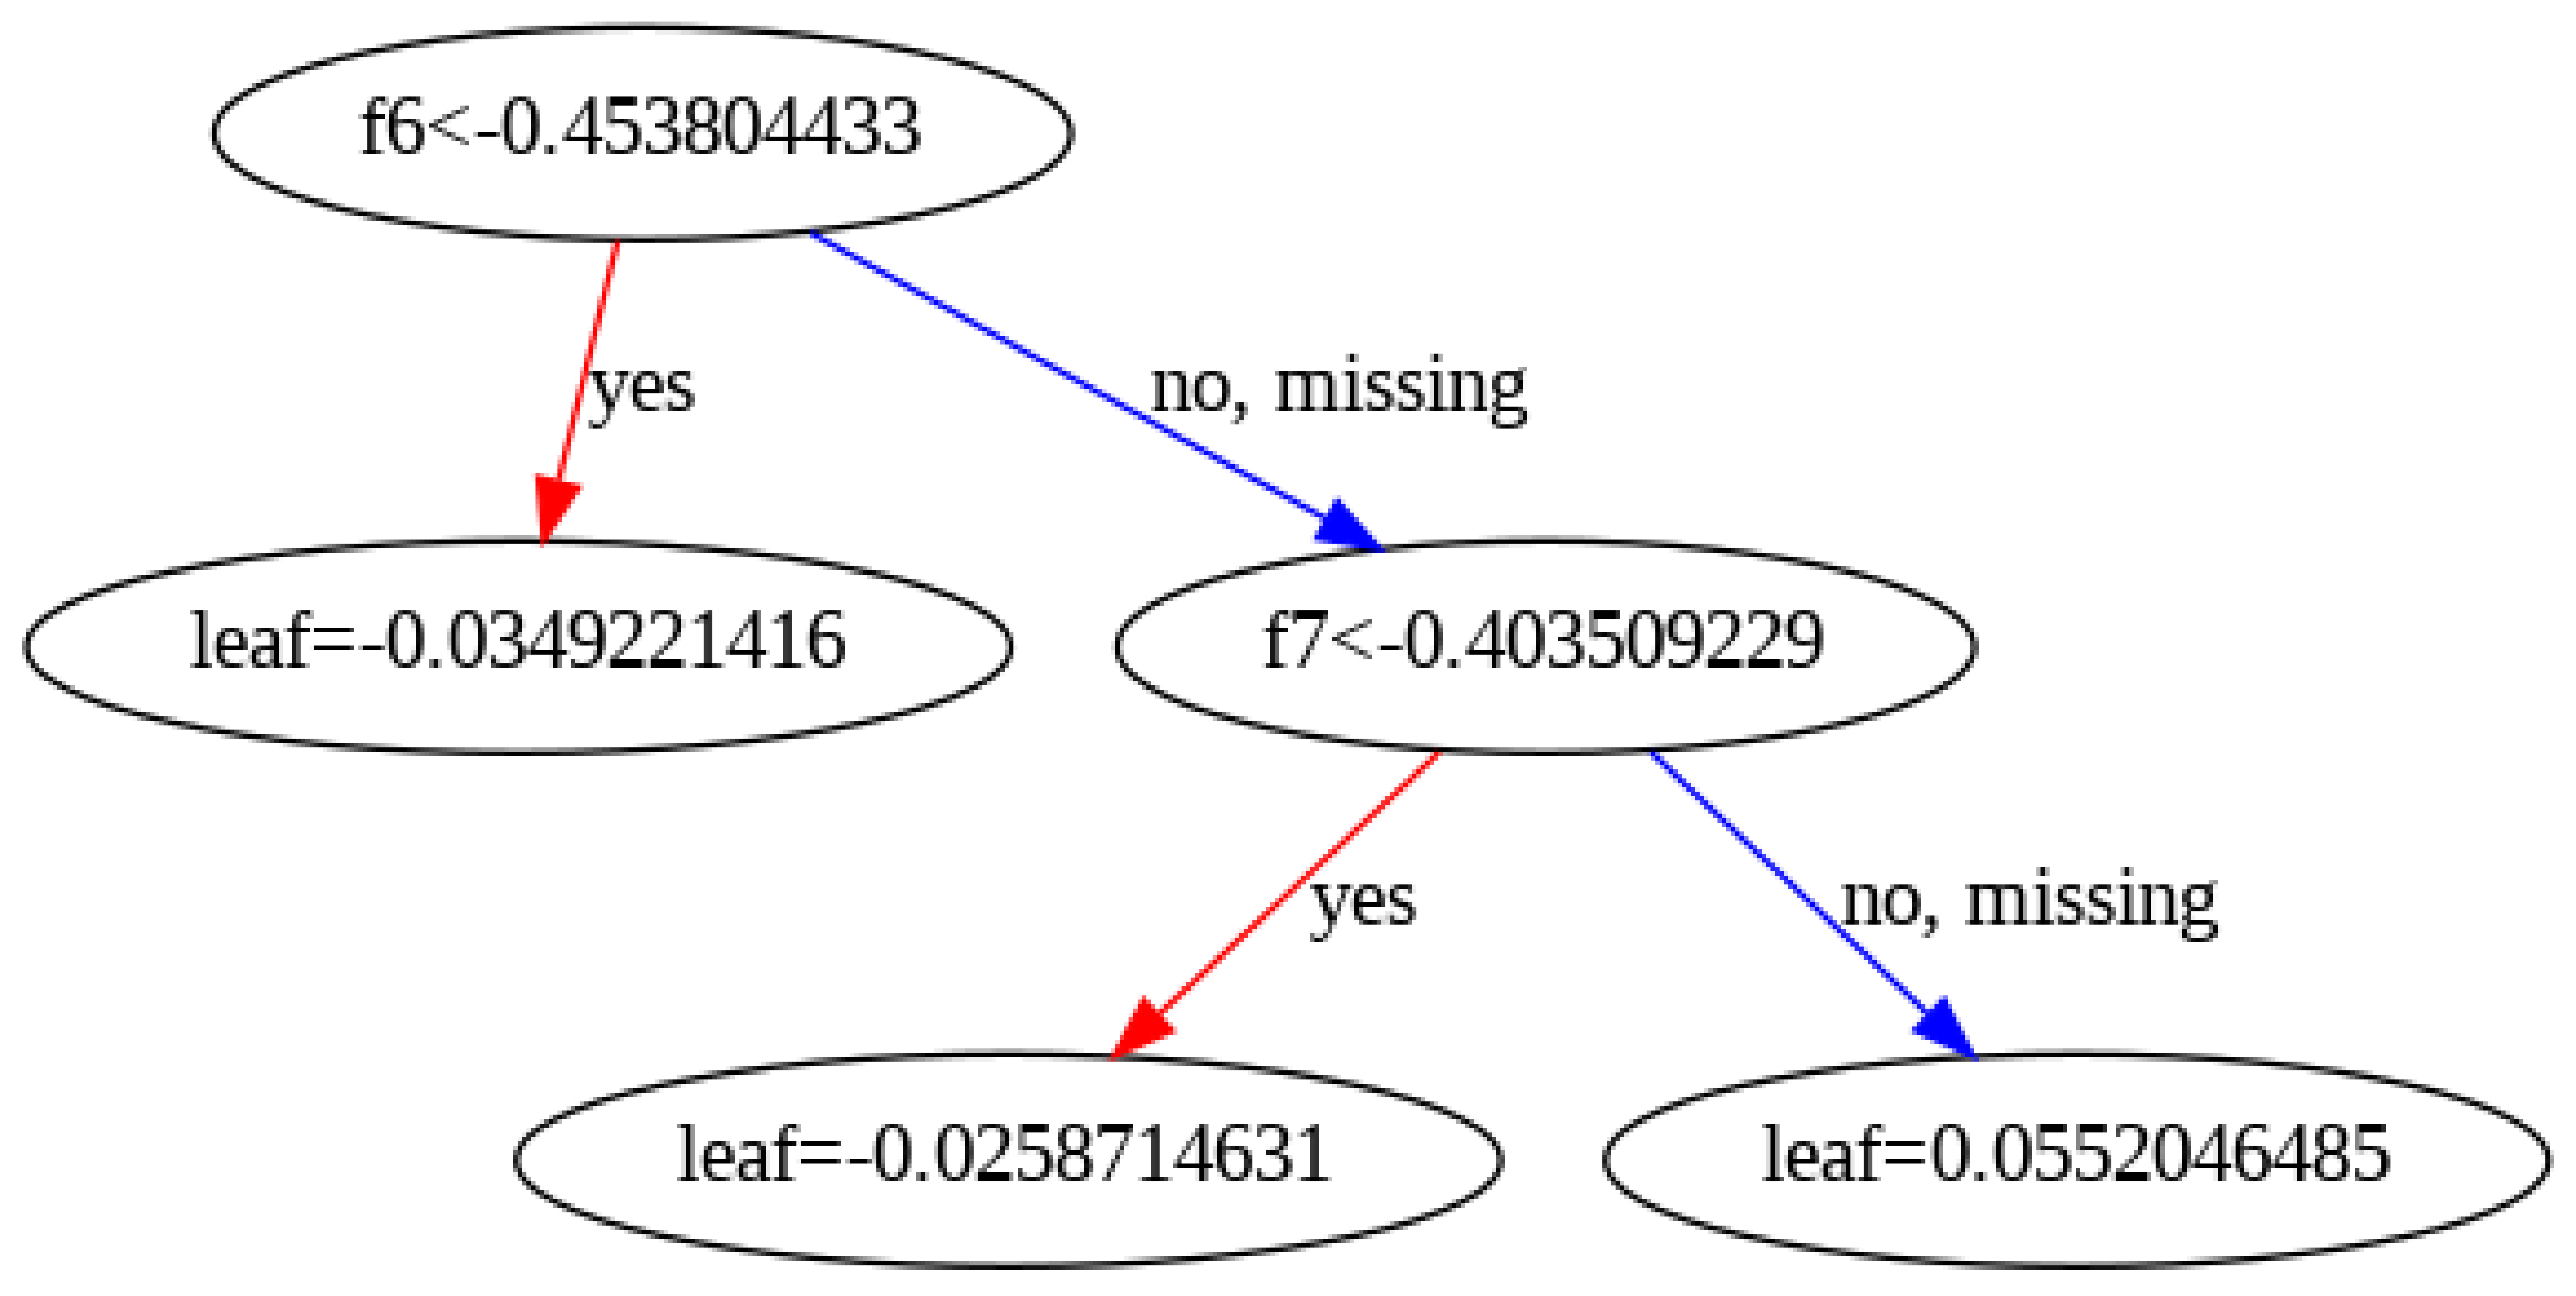

In [39]:
import xgboost as xgb
from matplotlib.pylab import rcParams

# 트리 시각화 설정
rcParams['figure.figsize'] = 80,80

# 첫 번째 트리 시각화
xgb.plot_tree(xgb_model_cls, num_trees=0)
xgb.plot_tree(xgb_model_cls, num_trees=99)

plt.show()



리프노드에 적힌 값들은 로지스틱 회귀 모델의 로짓(logit) 값

즉 leaf=-0.5면
1/e^-(-0.5) = 0.377
즉 화이트와인에 해당될 확률이 0.37임을 의미

#각 트리마다 reduction gain

In [33]:
# 모델의 Booster 객체 얻기
booster = xgb_model_cls.get_booster()

# 각 특성의 gain 출력
feature_gains = booster.get_score(importance_type='gain')
sorted_feature_gains = sorted(feature_gains.items(), key=lambda x: x[1], reverse=True)

# 출력
for feature, gain in sorted_feature_gains:
    print(f"Feature: {feature}, Reduction Gain: {gain}")


Feature: f6, Reduction Gain: 52.769676208496094
Feature: f4, Reduction Gain: 38.12623977661133
Feature: f1, Reduction Gain: 5.649079322814941
Feature: f7, Reduction Gain: 4.671739101409912
Feature: f9, Reduction Gain: 2.8907666206359863
Feature: f8, Reduction Gain: 2.840571880340576
Feature: f0, Reduction Gain: 1.1201750040054321
Feature: f3, Reduction Gain: 1.1184273958206177
Feature: f10, Reduction Gain: 0.9694621562957764
Feature: f2, Reduction Gain: 0.8822692632675171
Feature: f11, Reduction Gain: 0.415218323469162
Feature: f5, Reduction Gain: 0.41340550780296326
